In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Set all the Constants

In [59]:
# identify size of my images, and batch size 
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

Import data into tensorflow dataset object

In [5]:
# This code uses the Keras API from TensorFlow to create a dataset from a directory of images
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage', #The directory where the images are located.
    shuffle =True, #Whether or not to shuffle the images in the dataset.
    image_size = (IMAGE_SIZE,IMAGE_SIZE), #The desired size of the images in the dataset.
    batch_size = BATCH_SIZE)    #The number of images to include in each batch of the dataset                                    )

Found 2152 files belonging to 3 classes.


In [6]:
# understanding these tree classes (folder names)
class_names = dataset.class_names 
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
# length of my dataset 32 * 68 = 2176
len(dataset)

68

In [20]:
# Here we know that one batch has 32 images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1]


In [12]:
# Print the 1st image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[213. 202. 196.]
  [211. 200. 194.]
  [209. 198. 192.]
  ...
  [188. 177. 175.]
  [187. 176. 174.]
  [187. 176. 174.]]

 [[210. 199. 193.]
  [208. 197. 191.]
  [206. 195. 189.]
  ...
  [187. 176. 174.]
  [187. 176. 174.]
  [187. 176. 174.]]

 [[207. 196. 190.]
  [205. 194. 188.]
  [202. 191. 185.]
  ...
  [185. 174. 172.]
  [187. 176. 174.]
  [188. 177. 175.]]

 ...

 [[145. 121. 117.]
  [144. 120. 116.]
  [140. 116. 112.]
  ...
  [118.  98. 100.]
  [132. 110. 113.]
  [136. 114. 116.]]

 [[131. 107. 103.]
  [140. 116. 112.]
  [144. 120. 116.]
  ...
  [111.  91.  93.]
  [130. 108. 111.]
  [136. 114. 116.]]

 [[128. 104. 100.]
  [143. 119. 115.]
  [148. 124. 120.]
  ...
  [106.  86.  88.]
  [128. 106. 109.]
  [137. 115. 117.]]], shape=(256, 256, 3), dtype=float32)


Visualize some of the images from our dataset

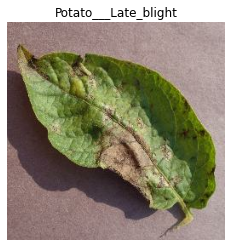

In [26]:
# print the 1st image 

for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]]) # here it will help to display name based on the image label
    plt.axis('off')

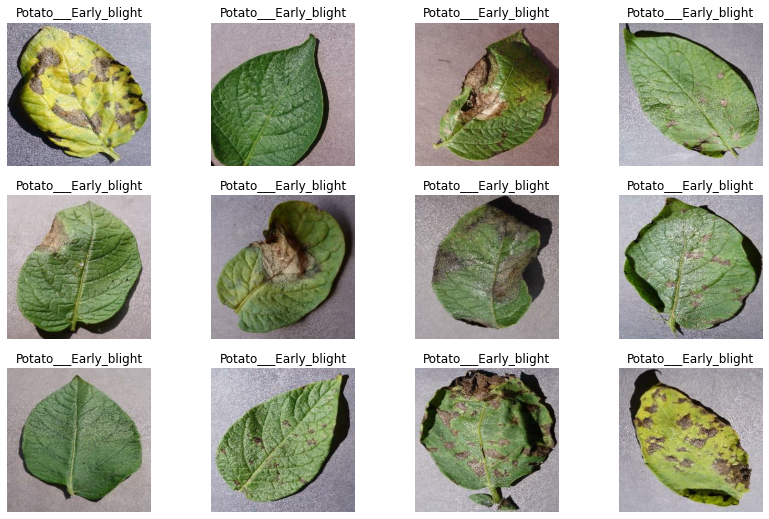

In [31]:
# display more images 
plt.figure(figsize = (14,9))
for image_batch, label_batch in dataset.take(1):
   for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[0]]) # here it will help to display name based on the image label
        plt.axis('off')

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [32]:
len(dataset)

68

In [ ]:
# Split
# 80% ===> will be trained 
# 20% ===> 10% validation and 10% for test

In [33]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [34]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [35]:
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [37]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [38]:
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [39]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [44]:
# function to take tensoflow data
def get_dataset_participation_tf(ds, train_split = .8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 100000):
    
    ds_size = len(ds)
    if shuffle:
        sd = ds.shuffle(shuffle_size, seed = 12)
        
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_dataset = ds.take(train_size)
    
    val_dataset = ds.skip(train_size)
    
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [41]:
train_dataset, val_dataset, test_dataset = get_dataset_participation_tf(dataset)

In [45]:
len(train_dataset)

54

In [46]:
len(val_dataset)

6

In [47]:
len(test_dataset)

8

Cache, Shuffle, and Prefetch the Dataset

In [51]:
# creating three different datasets for training, validation, and testing. 
train_datase = train_dataset.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_datase = test_dataset.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_datase = test_dataset.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)

#### Building the Model -  using layer resizing functions

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [53]:

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

##### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [54]:
# data augumentation is helping to make a robust of my model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [56]:
train_ds = train_datase.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

##### Model Architecture 
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [60]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

#### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [62]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 59s 1s/step - loss: 0.9154 - accuracy: 0.4757 - val_loss: 0.8392 - val_accuracy: 0.5365
Epoch 2/50
54/54 [==============================] - 64s 1s/step - loss: 0.7056 - accuracy: 0.6725 - val_loss: 0.5940 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 63s 1s/step - loss: 0.4136 - accuracy: 0.8310 - val_loss: 0.2182 - val_accuracy: 0.9219
Epoch 4/50
54/54 [==============================] - 70s 1s/step - loss: 0.2418 - accuracy: 0.9045 - val_loss: 0.5018 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 91s 2s/step - loss: 0.1741 - accuracy: 0.9271 - val_loss: 0.3366 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 83s 2s/step - loss: 0.1682 - accuracy: 0.9381 - val_loss: 0.3457 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 101s 2s/step - loss: 0.1756 - accuracy: 0.9329 - val_loss: 0.4745 - val_accuracy: 0.7865
Epoch 8/50
54/54 [=

In [65]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 6s 543ms/step - loss: 0.0384 - accuracy: 0.9871


You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [67]:
scores

[0.038408756256103516, 0.9870689511299133]

Scores is just a list containing loss and accuracy value

##### Plotting the Accuracy and Loss Curves